In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # your code here

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertModel, BertConfig, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [104]:
df= pd.read_csv('Sum_of_Ga!pageviews,_1749714445781.csv')

In [105]:
df.shape

(38571, 13)

In [106]:
df.isnull().sum()

id                      0
Title                   0
body                    0
Provider               19
Desk User            8762
Byline              19973
Date                    0
GA_content_type         0
section             18949
publicationlink        85
ga:pageviews         1950
ga:avgtimeonpage     1950
words                   0
dtype: int64

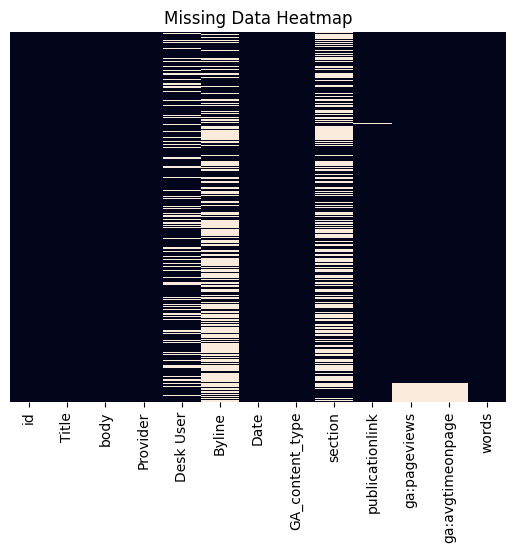

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()

In [19]:
# Basic Cleaning
df = df.dropna(subset=['ga:avgtimeonpage', 'ga:pageviews'])  # drop rows with missing required fields

In [20]:
df.isnull().sum()

id                      0
Title                   0
body                    0
Provider               19
Desk User            8315
Byline              18559
Date                    0
GA_content_type         0
section             17849
publicationlink        73
ga:pageviews            0
ga:avgtimeonpage        0
words                   0
dtype: int64

In [21]:
df.shape

(36621, 13)

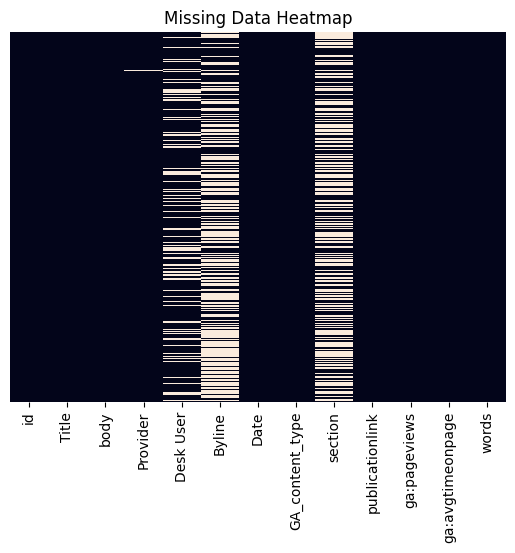

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()


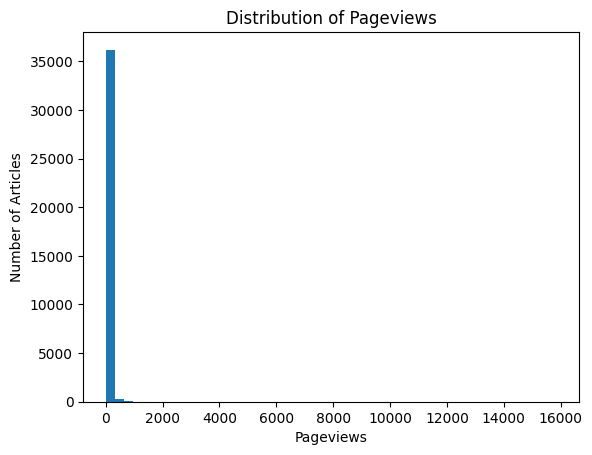

In [23]:
import matplotlib.pyplot as plt

plt.hist(df['ga:pageviews'], bins=50)
plt.title("Distribution of Pageviews")
plt.xlabel("Pageviews")
plt.ylabel("Number of Articles")
plt.show()


In [24]:
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False


df_1 = df[df["body"].apply(is_english)]
df_1 = df[df["Title"].apply(is_english)]

In [25]:
df_1.shape

(30494, 13)

In [26]:
df_1 = df_1.copy()
df_1['count'] = df_1['Title'].apply(lambda x: len(x.split()))


In [28]:
df_1['count'].describe()


count    30494.000000
mean        11.556601
std          3.612860
min          1.000000
25%          9.000000
50%         11.000000
75%         13.000000
max         64.000000
Name: count, dtype: float64

In [111]:
min_value = df_1['count'].min()
min_count = (df_1['count'] == min_value).sum()
print(f"Minimum value: {min_value}, Count: {min_count}")


Minimum value: 1, Count: 1


In [112]:
df_1['count'].value_counts().sort_index()


count
1        1
3        6
4       52
5      231
6      642
7     1615
8     2731
9     3675
10    4299
11    4104
12    3381
13    2643
14    2012
15    1400
16    1105
17     800
18     542
19     341
20     250
21     167
22     117
23      80
24      64
25      52
26      44
27      26
28      35
29      14
30      13
31      16
32       6
33       6
34       8
35       3
36       3
37       2
38       1
40       1
41       1
42       1
43       1
52       1
53       1
64       1
Name: count, dtype: int64

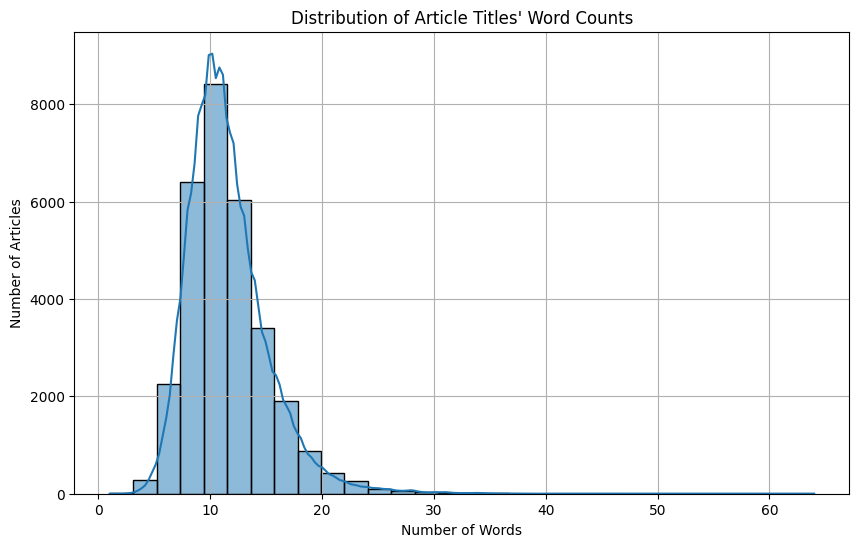

In [30]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_1['count'], bins=30, kde=True)
plt.title('''Distribution of Article Titles' Word Counts''')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

In [31]:
import html
from bs4 import BeautifulSoup
import re

def clean_html_text(text):
    if not isinstance(text, str) or not text.strip():
        return ''
    
    # Unescape HTML entities (e.g., &amp; -> &)
    text = html.unescape(text)
    
    # Remove HTML tags using BeautifulSoup
    try:
        text = BeautifulSoup(text, 'html.parser').get_text(separator=' ', strip=True)
    except Exception:
        pass  # fallback if BS fails
    
    # Remove any remaining HTML tags (just in case)
    text = re.sub(r'</?[a-zA-Z0-9]+[^>]*>', '', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


In [32]:
df_1['title_clean'] = df_1['Title'].apply(clean_html_text)


In [36]:
df_1['title_clean'][2]

'HSBC lays off about 40 bankers in Hong Kong'

In [37]:
df_1['Title'][2]

'<h1>HSBC lays off about 40 bankers in Hong Kong</h1>\n'

In [40]:
df_2=df_1.copy()

In [ ]:
df_2.reset_index(drop=True)

In [84]:
df_2['count_Title'] = df_2['title_clean'].apply(lambda x: len(x.split()))

In [85]:
df_2['count_Title'].describe()

count    30494.000000
mean        11.585000
std          3.591947
min          3.000000
25%          9.000000
50%         11.000000
75%         13.000000
max         64.000000
Name: count_Title, dtype: float64

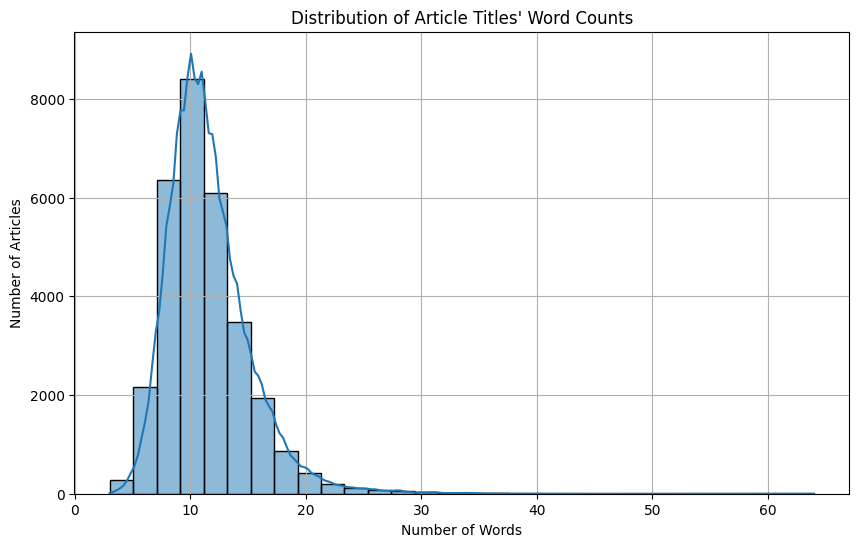

In [86]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_2['count_Title'], bins=30, kde=True)
plt.title('''Distribution of Article Titles' Word Counts''')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

In [87]:
df_2[['count_Title','count']].describe()

,count_Title,count
count,30494.000000,30494.000000
mean,11.585000,11.556601
std,3.591947,3.612860
min,3.000000,1.000000
25%,9.000000,9.000000
50%,11.000000,11.000000
75%,13.000000,13.000000
max,64.000000,64.000000


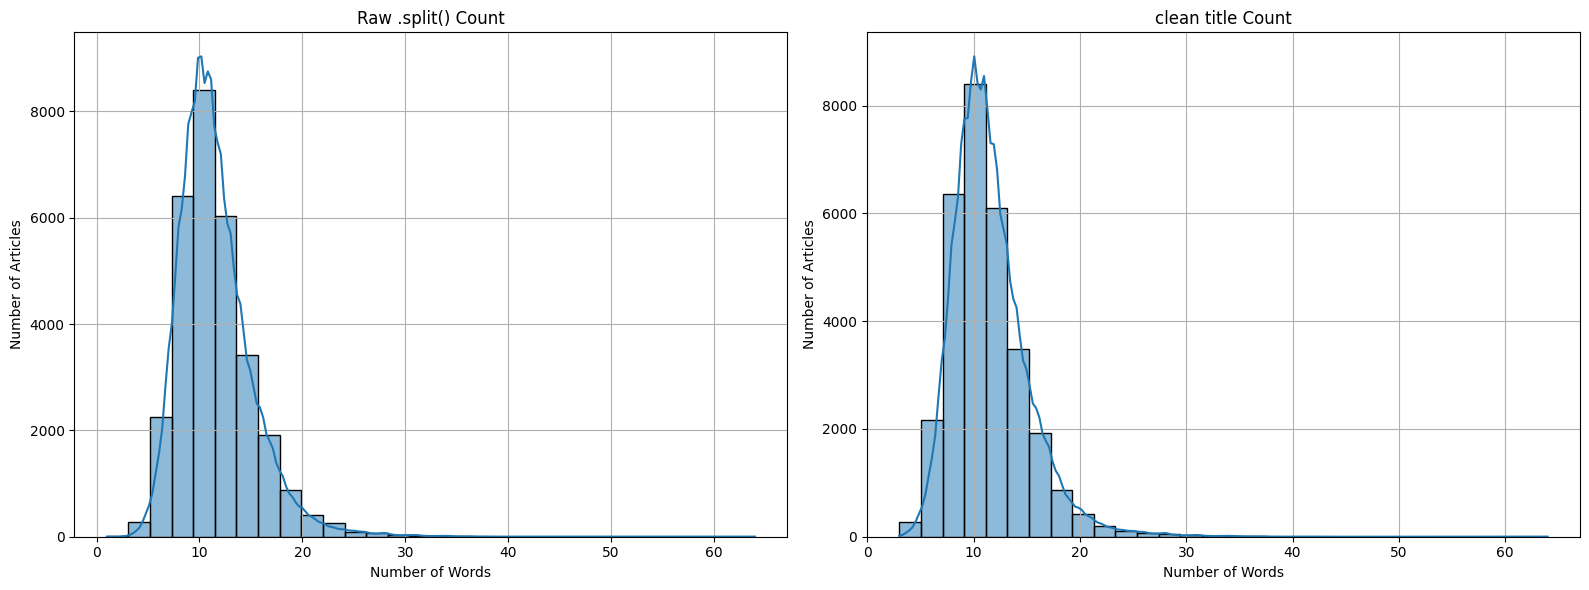

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'count' and 'count_Title' exist and are numeric
assert 'count' in df_2.columns and 'count_Title' in df_2.columns, "Missing columns!"
df_2['count'] = pd.to_numeric(df_2['count'], errors='coerce')
df_2['count_Title'] = pd.to_numeric(df_2['count_Title'], errors='coerce')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot 1: Basic .split() count
sns.histplot(df_2['count'].dropna(), bins=30, kde=True, ax=axs[0])
axs[0].set_title('Raw .split() Count')
axs[0].set_xlabel('Number of Words')
axs[0].set_ylabel('Number of Articles')
axs[0].grid(True)

# Plot 2: spaCy Token Count
sns.histplot(df_2['count_Title'].dropna(), bins=30, kde=True, ax=axs[1])
axs[1].set_title('clean title Count')
axs[1].set_xlabel('Number of Words')
axs[1].set_ylabel('Number of Articles')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [89]:
df_2.columns

Index(['id', 'Title', 'body', 'Provider', 'Desk User', 'Byline', 'Date',
       'GA_content_type', 'section', 'publicationlink', 'ga:pageviews',
       'ga:avgtimeonpage', 'words', 'count', 'title_clean', 'count_Title',
       'views'],
      dtype='object')

In [113]:
percentiles = df_2['count_Title'].quantile([0.50, 0.75, 0.90, 0.95, 0.99])
print(percentiles)

0.50    11.0
0.75    13.0
0.90    16.0
0.95    18.0
0.99    23.0
Name: count_Title, dtype: float64


In [90]:
df_2['views'] = df_2['ga:pageviews'].astype(float)

In [91]:
percentiles = df_2['views'].quantile([0.50, 0.75, 0.90, 0.95, 0.99])
print(percentiles)

0.50     27.00
0.75     51.00
0.90     96.00
0.95    145.00
0.99    360.07
Name: views, dtype: float64


In [92]:
percentiles1 = df_2['ga:avgtimeonpage'].quantile([0.50, 0.75, 0.90, 0.95, 0.99])
print(percentiles1)

0.50     3.714300
0.75     6.200000
0.90     9.926910
0.95    13.405505
0.99    26.256437
Name: ga:avgtimeonpage, dtype: float64


In [93]:
# Define 95th percentile thresholds
view_threshold = 146
time_threshold = 13.41

# Apply the combined filter
df_3 = df_2[(df_2['views'] <= view_threshold) & (df_2['ga:avgtimeonpage'] <= time_threshold)].copy()

# Reset index
df_3 = df_3.reset_index(drop=True)

# Display the results
print(f"Original Dataset Size: {len(df_2)}")
print(f"Filtered Dataset Size: {len(df_3)}")
print(df_3[['views', 'ga:avgtimeonpage']].head())

Original Dataset Size: 30494
Filtered Dataset Size: 28247
   views  ga:avgtimeonpage
0  146.0           12.1144
1  146.0           13.0353
2  146.0           12.8190
3  146.0           11.0922
4  146.0            8.7607


In [94]:
df_2['views'].describe()

count    30494.000000
mean        52.086640
std        212.278697
min          1.000000
25%         14.000000
50%         27.000000
75%         51.000000
max      15857.000000
Name: views, dtype: float64

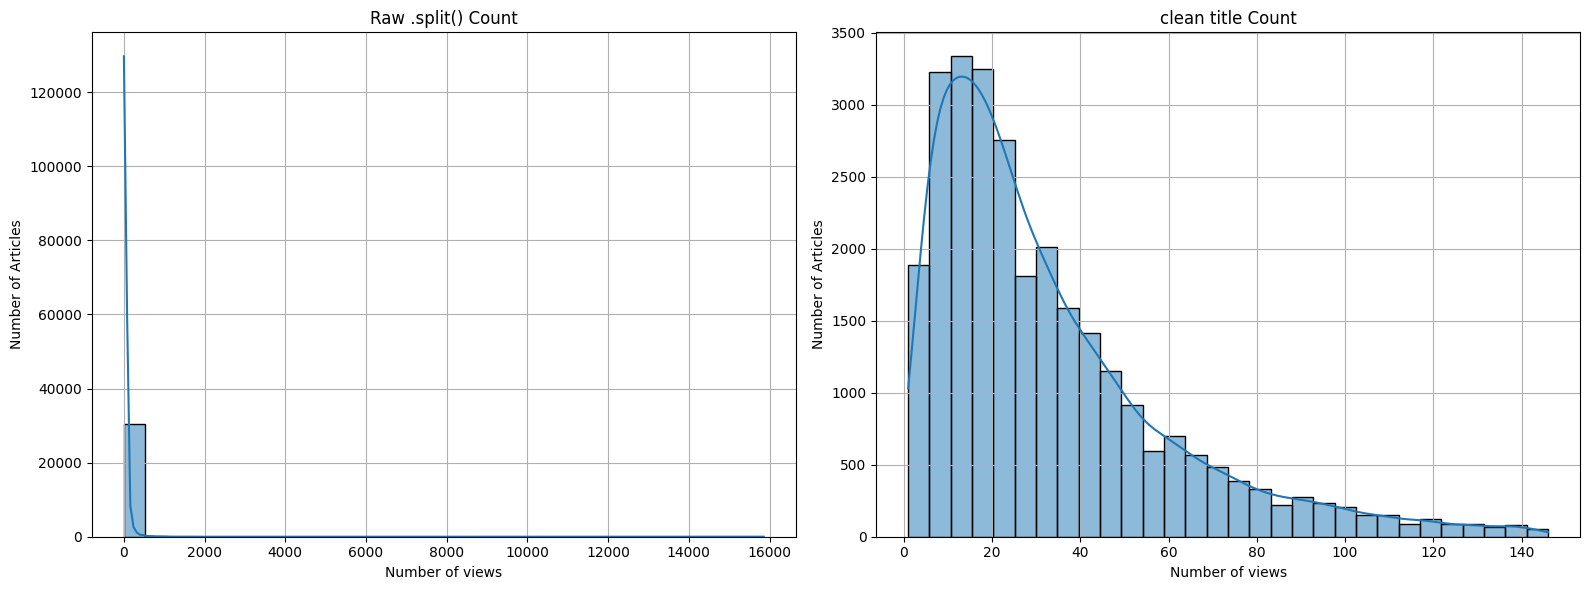

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'count' and 'count_Title' exist and are numeric
#assert 'count' in df_2.columns and 'count_Title' in df_2.columns, "Missing columns!"
#df_2['count'] = pd.to_numeric(df_2['count'], errors='coerce')
#df_2['count_Title'] = pd.to_numeric(df_2['count_Title'], errors='coerce')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot 1: Basic .split() count
sns.histplot(df_2['views'].dropna(), bins=30, kde=True, ax=axs[0])
axs[0].set_title('Raw .split() Count')
axs[0].set_xlabel('Number of views')
axs[0].set_ylabel('Number of Articles')
axs[0].grid(True)

# Plot 2: spaCy Token Count
sns.histplot(df_3['views'].dropna(), bins=30, kde=True, ax=axs[1])
axs[1].set_title('clean title Count')
axs[1].set_xlabel('Number of views')
axs[1].set_ylabel('Number of Articles')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [96]:
df_3.drop_duplicates(['title_clean' ], inplace = True )

print(df_3.shape)

(27757, 17)


In [97]:
median_views = df_3['views'].median()

# Assign labels based on the median
final_df = df_3.copy()
final_df['label'] = (final_df['views'] >= median_views).astype(int)

# Reset index
final_df = final_df.reset_index(drop=True)

In [98]:
counts = final_df['label'].value_counts()
percentages = final_df['label'].value_counts(normalize=True).round(3)

summary = pd.DataFrame({
    'count': counts,
    'percentage': percentages
})

print(summary)

       count  percentage
label                   
1      14139       0.509
0      13618       0.491


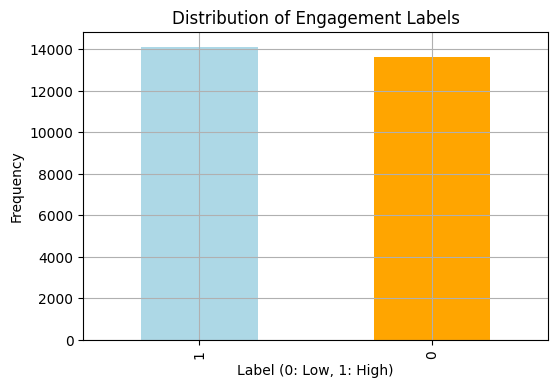

In [102]:
# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
final_df['label'].value_counts().plot(kind='bar', color=['lightblue', 'orange'])
plt.title('Distribution of Engagement Labels')
plt.xlabel('Label (0: Low, 1: High)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

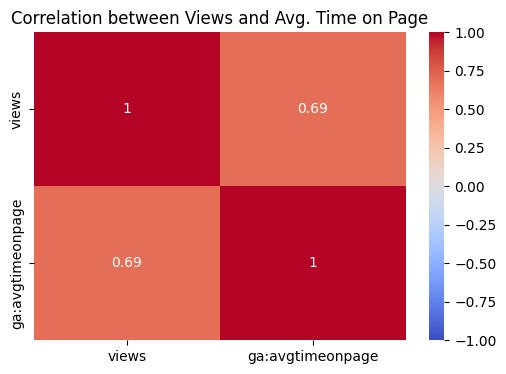

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation
correlation = final_df[['views', 'ga:avgtimeonpage']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Views and Avg. Time on Page')
plt.show()


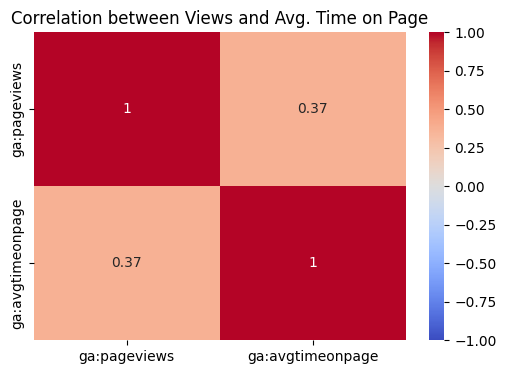

In [100]:
#correlation = df[['views', 'ga:avgtimeonpage']].corr()

# Compute correlation
correlation = df[['ga:pageviews', 'ga:avgtimeonpage']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Views and Avg. Time on Page')
plt.show()


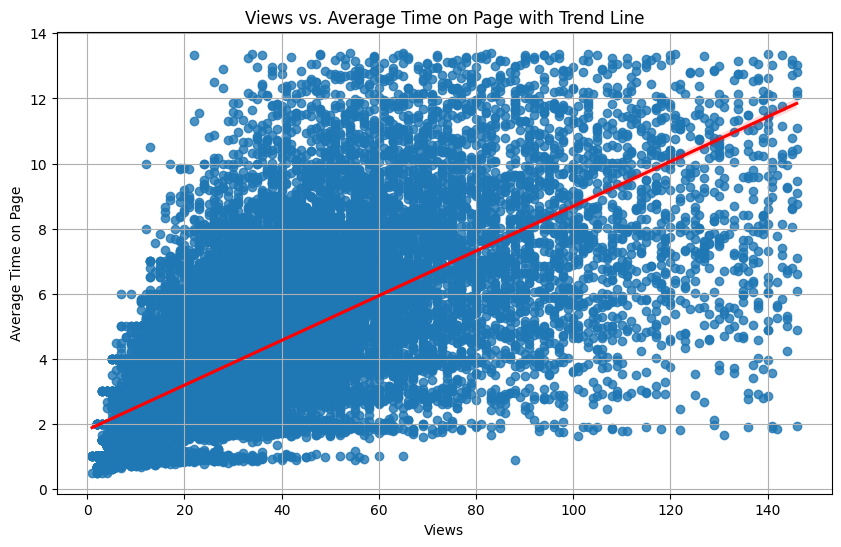

In [101]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(x='views', y='ga:avgtimeonpage', data=final_df, scatter=True, line_kws={"color": "red"})
plt.title('Views vs. Average Time on Page with Trend Line')
plt.xlabel('Views')
plt.ylabel('Average Time on Page')
plt.grid(True)
plt.show()

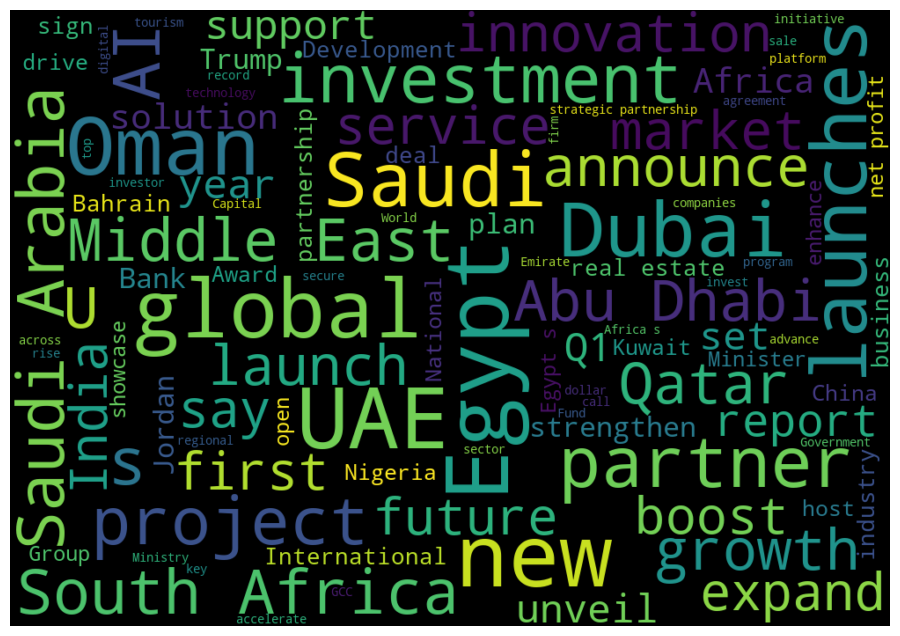

In [103]:
from wordcloud import WordCloud
txt = ' '.join(rev for rev in final_df.title_clean )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100, 
    width=1000, 
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()

In [130]:
X= final_df['title_clean'].tolist()
y= final_df['label'].tolist()

In [131]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel
# Import AdamW optimizer from TensorFlow Keras optimizers
from tensorflow.keras.optimizers import AdamW

In [132]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical


# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Second split: 15% validation, 15% test (from remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)


In [133]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
max_len = 64

def tokenize_data(texts):
    return tokenizer(
        text=texts,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True
    )


In [135]:
# Tokenize each dataset split
train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)
test_encodings = tokenize_data(X_test)


In [136]:
print("Train input_ids shape:", train_encodings['input_ids'].shape)
print("Train attention_mask shape:", train_encodings['attention_mask'].shape)

print("Val input_ids shape:", val_encodings['input_ids'].shape)
print("Test input_ids shape:", test_encodings['input_ids'].shape)


Train input_ids shape: (19429, 64)
Train attention_mask shape: (19429, 64)
Val input_ids shape: (4164, 64)
Test input_ids shape: (4164, 64)


In [137]:
sample_text = X_train[0]
print("Original text:", sample_text)

tokens = tokenizer.tokenize(sample_text)
print("Tokens:", tokens)

ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token IDs:", ids)


Original text: Game-changer: beIN SPORTS to broadcast all 18 UEFA Champions League matches simultaneously
Tokens: ['Game', '-', 'change', '##r', ':', 'be', '##IN', 'SP', '##OR', '##TS', 'to', 'broadcast', 'all', '18', 'UEFA', 'Champions', 'League', 'matches', 'simultaneously']
Token IDs: [3497, 118, 1849, 1197, 131, 1129, 11607, 16625, 9565, 11365, 1106, 3012, 1155, 1407, 6068, 4748, 1453, 2697, 7344]


In [138]:
decoded = tokenizer.decode(train_encodings['input_ids'][0], skip_special_tokens=True)
print("Decoded back:", decoded)


Decoded back: Game - changer : beIN SPORTS to broadcast all 18 UEFA Champions League matches simultaneously


In [139]:
import numpy as np

print("y_train:", np.unique(y_train, return_counts=True))
print("y_val:", np.unique(y_val, return_counts=True))
print("y_test:", np.unique(y_test, return_counts=True))


y_train: (array([0, 1]), array([9532, 9897]))
y_val: (array([0, 1]), array([2043, 2121]))
y_test: (array([0, 1]), array([2043, 2121]))


In [140]:
assert train_encodings['input_ids'].shape[0] == len(y_train), "Mismatch in train set!"
assert val_encodings['input_ids'].shape[0] == len(y_val), "Mismatch in val set!"
assert test_encodings['input_ids'].shape[0] == len(y_test), "Mismatch in test set!"
print("All sizes match ✅")


All sizes match ✅


In [141]:

# --- Custom BERT Embedding Layer ---
class BertEmbedding(tf.keras.layers.Layer):
    """
    A custom Keras layer to wrap the Hugging Face TFAutoModel.
    This allows BERT to be integrated directly into a Keras Sequential or Functional API model.
    """
    def __init__(self, model, **kwargs):
        super(BertEmbedding, self).__init__(**kwargs)
        self.bert = model # The pre-trained TFAutoModel

    def call(self, inputs):
        # Call the BERT model with input_ids and attention_mask
        # bert(inputs)[0] returns the last_hidden_state (sequence of contextual embeddings)
        return self.bert(inputs)[0]

# --- Model Definition (BERT + CNN) ---
# Load pretrained BERT model
# Set trainable=True to fine-tune BERT weights during training
bert_model = TFAutoModel.from_pretrained('bert-base-cased')
bert_model.trainable = True

# Define input layers for BERT
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

# Pass BERT inputs through the custom BertEmbedding layer
# The output 'bert_output' has shape (batch_size, sequence_length, hidden_size)
bert_output = BertEmbedding(bert_model)({'input_ids': input_ids, 'attention_mask': attention_mask})


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [143]:
# Add CNN layer
# Conv1D extracts local features (n-grams) from the BERT embeddings
conv = tf.keras.layers.Conv1D(1024, kernel_size=3, activation='relu', name='conv_layer')(bert_output)
# GlobalMaxPooling1D pools the most prominent features across the sequence
pool = tf.keras.layers.GlobalMaxPooling1D(name='global_max_pooling_layer')(conv)

# Add Dense (fully connected) layers for classification
dense1 = tf.keras.layers.Dense(512, activation='relu', name='dense_layer_1')(pool)
dense2 = tf.keras.layers.Dense(256, activation='relu', name='dense_layer_2')(dense1)
# Dropout for regularization to prevent overfitting
dropout = tf.keras.layers.Dropout(0.2, name='dropout_layer')(dense2)

# Output layer for binary classification
# Sigmoid activation outputs a probability between 0 and 1
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(dropout)

# Build the complete Keras model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# --- Create TensorFlow Datasets ---
# Define batch size
batch_size = 16


def create_dataset(encodings, labels):
    """
    Creates a tf.data.Dataset from tokenized inputs and labels.
    """
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))

# Create datasets for training, validation, and testing
# Shuffle training data, batch all datasets, and prefetch for performance
train_dataset = create_dataset(train_encodings, y_train).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(val_encodings, y_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = create_dataset(test_encodings, y_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [149]:
# --- Learning Rate Schedule and Optimizer ---
epochs = 10
initial_learning_rate = 5e-5 # Initial learning rate from your original code
warmup_steps_ratio = 0.1 # Percentage of total steps for warmup (e.g., 10%)
weight_decay = 0.01 # Common weight decay for AdamW

# Calculate total training steps
# Using len(X_train) for robust calculation, especially if tf.data.Dataset.cardinality is UNKNOWN
num_train_samples = len(X_train)
num_train_batches = num_train_samples // batch_size + (1 if num_train_samples % batch_size else 0)
num_train_steps = num_train_batches * epochs

num_warmup_steps = int(num_train_steps * warmup_steps_ratio)

class LinearWarmupLinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, num_warmup_steps, num_train_steps, min_lr_ratio=0.0):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.num_warmup_steps = tf.cast(num_warmup_steps, dtype=tf.float32)
        self.num_train_steps = tf.cast(num_train_steps, dtype=tf.float32)
        self.min_lr_ratio = tf.cast(min_lr_ratio, dtype=tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)

        warmup_lr = self.initial_learning_rate * (step / self.num_warmup_steps)

        decay_factor = 1.0 - ((step - self.num_warmup_steps) / (self.num_train_steps - self.num_warmup_steps))
        decay_factor = tf.maximum(self.min_lr_ratio, decay_factor)
        decayed_lr = self.initial_learning_rate * decay_factor

        return tf.cond(
            step < self.num_warmup_steps,
            lambda: warmup_lr,
            lambda: decayed_lr
        )


# Instantiate the custom learning rate schedule
lr_schedule = LinearWarmupLinearDecay(
    initial_learning_rate=initial_learning_rate,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps
)

# Instantiate the AdamW optimizer with the learning rate schedule and weight decay
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=weight_decay)


In [150]:
# --- Model Compilation ---
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', # Appropriate loss for binary classification with sigmoid output
              metrics=['accuracy'])      # Monitor accuracy during training

# Display model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_embedding      │ (None, 64, 768)   │          0 │ attention_mask[0… │
│ (BertEmbedding)     │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_layer (Conv1D) │ (None, 62, 1024)  │  2,360,320 │ bert_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1024)      │          0 │ conv_layer[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_1       │ (None, 512)       │    524,800 │ global_max_pooli… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_2       │ (None, 256)       │    131,328 │ dense_layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 256)       │          0 │ dense_layer_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │        257 │ dropout_layer[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,016,705 (11.51 MB)

 Trainable params: 3,016,705 (11.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Model Training ---
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs # Number of training epochs
)


######################
####################
#################
#############
########

In [160]:
# First dense layer
dense1 = tf.keras.layers.Dense(512, activation='relu', name='dense_layer_1')(pool)

# Dropout after dense1
dropout1 = tf.keras.layers.Dropout(0.3, name='dropout_layer_1')(dense1)

# Second dense layer
dense2 = tf.keras.layers.Dense(256, activation='relu', name='dense_layer_2')(dropout1)

# Dropout after dense2
dropout2 = tf.keras.layers.Dropout(0.3, name='dropout_layer_2')(dense2)

# Third dense layer
dense3 = tf.keras.layers.Dense(128, activation='relu', name='dense_layer_3')(dropout2)

# Final dropout
dropout = tf.keras.layers.Dropout(0.2, name='dropout_layer_3')(dense3)

# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(dropout)


# Build the complete Keras model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

# --- Create TensorFlow Datasets ---
# Define batch size
batch_size = 32


def create_dataset(encodings, labels):
    """
    Creates a tf.data.Dataset from tokenized inputs and labels.
    """
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))

# Create datasets for training, validation, and testing
# Shuffle training data, batch all datasets, and prefetch for performance
train_dataset = create_dataset(train_encodings, y_train).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = create_dataset(val_encodings, y_val).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = create_dataset(test_encodings, y_test).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [161]:
# --- Learning Rate Schedule and Optimizer ---
epochs = 5
initial_learning_rate = 3e-5 # Initial learning rate from your original code
warmup_steps_ratio = 0.1 # Percentage of total steps for warmup (e.g., 10%)
weight_decay = 0.01 # Common weight decay for AdamW

# Calculate total training steps
# Using len(X_train) for robust calculation, especially if tf.data.Dataset.cardinality is UNKNOWN
num_train_samples = len(X_train)
num_train_batches = num_train_samples // batch_size + (1 if num_train_samples % batch_size else 0)
num_train_steps = num_train_batches * epochs

num_warmup_steps = int(num_train_steps * warmup_steps_ratio)

class LinearWarmupLinearDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, num_warmup_steps, num_train_steps, min_lr_ratio=0.0):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.num_warmup_steps = tf.cast(num_warmup_steps, dtype=tf.float32)
        self.num_train_steps = tf.cast(num_train_steps, dtype=tf.float32)
        self.min_lr_ratio = tf.cast(min_lr_ratio, dtype=tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)

        warmup_lr = self.initial_learning_rate * (step / self.num_warmup_steps)

        decay_factor = 1.0 - ((step - self.num_warmup_steps) / (self.num_train_steps - self.num_warmup_steps))
        decay_factor = tf.maximum(self.min_lr_ratio, decay_factor)
        decayed_lr = self.initial_learning_rate * decay_factor

        return tf.cond(
            step < self.num_warmup_steps,
            lambda: warmup_lr,
            lambda: decayed_lr
        )


# Instantiate the custom learning rate schedule
lr_schedule = LinearWarmupLinearDecay(
    initial_learning_rate=initial_learning_rate,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps
)

# Instantiate the AdamW optimizer with the learning rate schedule and weight decay
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=weight_decay)


In [162]:
# --- Model Compilation ---
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', # Appropriate loss for binary classification with sigmoid output
              metrics=['accuracy'])      # Monitor accuracy during training

# Display model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_embedding      │ (None, 64, 768)   │          0 │ attention_mask[0… │
│ (BertEmbedding)     │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_layer (Conv1D) │ (None, 64, 512)   │  1,180,160 │ bert_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ conv_layer[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_1       │ (None, 512)       │    262,656 │ global_max_pooli… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer_1     │ (None, 512)       │          0 │ dense_layer_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_2       │ (None, 256)       │    131,328 │ dropout_layer_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer_2     │ (None, 256)       │          0 │ dense_layer_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_3       │ (None, 128)       │     32,896 │ dropout_layer_2[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer_3     │ (None, 128)       │          0 │ dense_layer_3[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │        129 │ dropout_layer_3[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,607,169 (6.13 MB)

 Trainable params: 1,607,169 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
# --- Model Training ---
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs= 5 # Number of training epochs
)


Epoch 1/5
608/608 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.7282 - loss: 0.5457 - val_accuracy: 0.7123 - val_loss: 0.5598
Epoch 2/5
608/608 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.7283 - loss: 0.5466 - val_accuracy: 0.7123 - val_loss: 0.5598
Epoch 3/5
608/608 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - accuracy: 0.7284 - loss: 0.5464 - val_accuracy: 0.7123 - val_loss: 0.5598
Epoch 4/5
608/608 ━━━━━━━━━━━━━━━━━━━━ 605s 995ms/step - accuracy: 0.7278 - loss: 0.5480 - val_accuracy: 0.7123 - val_loss: 0.5598
Epoch 5/5
608/608 ━━━━━━━━━━━━━━━━━━━━ 875s 1s/step - accuracy: 0.7257 - loss: 0.5456 - val_accuracy: 0.7123 - val_loss: 0.5598


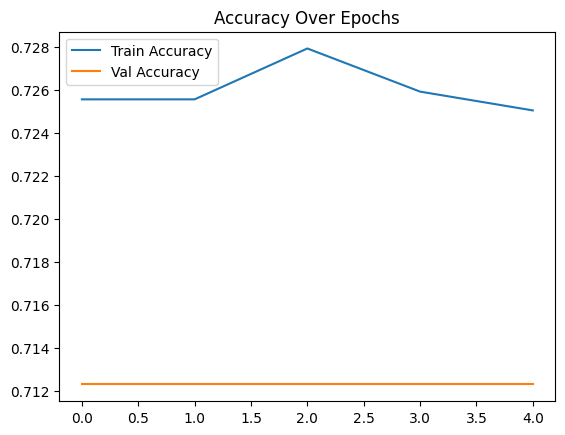

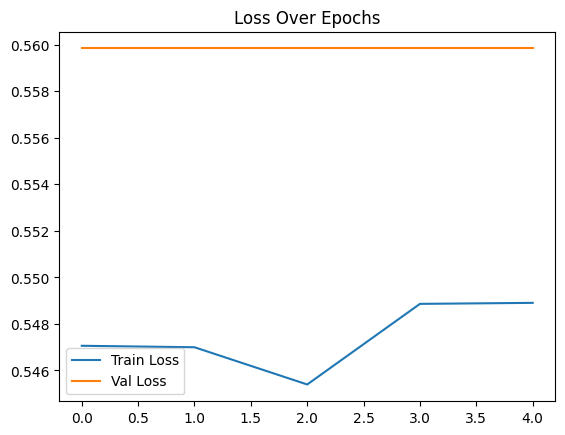

In [168]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()
